In [1]:
import pandas as pd
import numpy as np

import json

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_lg

nlp = en_core_web_lg.load()

In [2]:
import re
import string

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


Using TensorFlow backend.


In [3]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
import seaborn as sns
sns.set()
from IPython.core.pylabtools import figsize
figsize(20, 20)

In [5]:
# Just disable some annoying warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Dataset
Name:              **20 Newsgroups**

Size:              **18828**

Number of classes: **20**
URL: [http://qwone.com/~jason/20Newsgroups/](http://qwone.com/~jason/20Newsgroups/)

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. To the best of my knowledge, it was originally collected by Ken Lang, probably for his Newsweeder: Learning to filter netnews paper, though he does not explicitly mention this collection. The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.

# Read and parse dataset

In [6]:
df = pd.read_csv('../input/newsgroup20bbcnews/news_group20.csv')

# Dataset investigation

## Samples Count

In [7]:
df.count()

Unnamed: 0    18828
id            18828
category      18828
text          18828
dtype: int64

## Labels distribution

From the graph below we see that our dataset is unbalanced. For classes `talk.religion.misc`, `talk.politics.misc`, `alt.atheism` we have a lot fewer samples, so that our classifier could be skewed towards bigger balanced labels.

These are the options to solve this issue:
1. Undersampling - deleting samples from bigger classes in order to balance dataset. One of the most important points here is to keep the initial sample distribution inside the class group.
2. Oversampling - generating new samples inside the minor classes in order to balance dataset. One of the most crucial issues here is that newly generated samples could represent fake-good distribution in the class group, which will not match to its real distribution.
3. Balancing between under- and over- sampling
4. Do nothing (don't solve the issue, but it is always an option :) )

Any of these options are possible when features from text are extracted, so it would be discussed later.

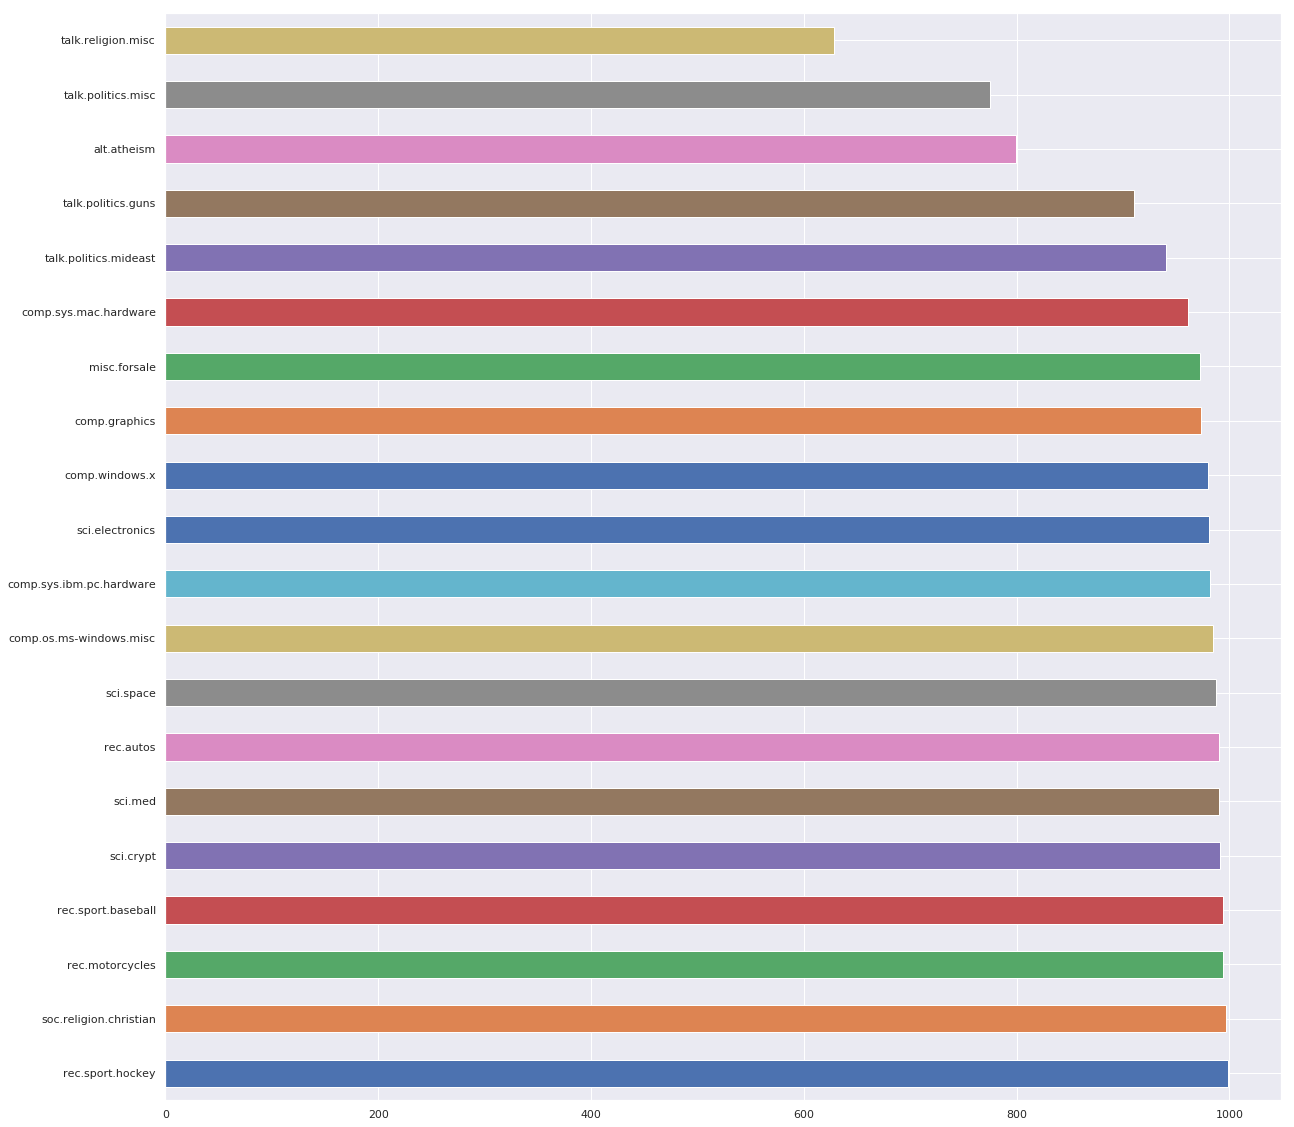

In [8]:
df.category.value_counts().plot.barh()

# Dataset preprocessing and feature extraction

## Text preprocessing 

In order to extract features from raw text, we have to somehow preprocess it. Typical simplified text preprocessing workflow:

<img src="https://i.ibb.co/Prrpgxg/nlp-preproc.png" />

1. **Tokenization** - inteligent splitting text into some kind of tokens (sentences, words, etc.)
2. **Cleaning** - cleaning text from all undesirable symbols or tokens or lines or whatever, it could be for example stop words or punctuation. 
3. **Steaming** - rocess of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language. [refference](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python)
4. **Lemmatization** - unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words. [refference](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python)
5. **Feature extraction** - vectorization of the ouput stems/lemmas. For example counting for each document or using TF-IDF.

In our case I have chosen such workflow:
1. **Tokenization** - using [spaCy](https://spacy.io/) python library
2. **Cleaning** - after investigating the content of raw emails, I have decided the next steps:
    1. Delete symbols ```!"#%&\'*+,-<=>?[\\]^_`{|}~```
    2. Delete lines, which begins with `From:` or end with `writes:`, autogenerated content by email host.
    3. Delete `email strings`, `From:`, `Re:`, `Subject:`
    4. Delete numbers
3. **Lemmatization** - I have chosen lemmatization(`spaCy`) in favor of steaming(`nltk`), because it has shown ability to generate more robust results. I've used [spaCy](https://spacy.io/) python library. 
4. **Feature extraction** - TF-IDF

In [9]:
import re
import string

from sklearn.base import TransformerMixin

class TextPreprocessor(TransformerMixin):
    def __init__(self, text_attribute):
        self.text_attribute = text_attribute
        
    def transform(self, X, *_):
        X_copy = X.copy()
        X_copy[self.text_attribute] = X_copy[self.text_attribute].apply(self._preprocess_text)
        return X_copy
    
    def _preprocess_text(self, text):
        return self._lemmatize(self._leave_letters_only(self._clean(text)))
    
    def _clean(self, text):
        bad_symbols = '!"#%&\'*+,-<=>?[\\]^_`{|}~'
        text_without_symbols = text.translate(str.maketrans('', '', bad_symbols))

        text_without_bad_words = ''
        for line in text_without_symbols.split('\n'):
            if not line.lower().startswith('from:') and not line.lower().endswith('writes:'):
                text_without_bad_words += line + '\n'

        clean_text = text_without_bad_words
        email_regex = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
        regexes_to_remove = [email_regex, r'Subject:', r'Re:']
        for r in regexes_to_remove:
            clean_text = re.sub(r, '', clean_text)

        return clean_text
    
    def _leave_letters_only(self, text):
        text_without_punctuation = text.translate(str.maketrans('', '', string.punctuation))
        return ' '.join(re.findall("[a-zA-Z]+", text_without_punctuation))
    
    def _lemmatize(self, text):
        doc = nlp(text)
        words = [x.lemma_ for x in [y for y in doc if not y.is_stop and y.pos_ != 'PUNCT' 
                                    and y.pos_ != 'PART' and y.pos_ != 'X']]
        return ' '.join(words)
    
    def fit(self, *_):
        return self

In [10]:
text_preprocessor = TextPreprocessor(text_attribute='text')
df_preprocessed = text_preprocessor.transform(df)

### Feature extraction

To train TF-IDF vectorizer we have to split our dataset into `train`/`test` parts, I have chosen typical `70`/`30` ratio.

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_preprocessed, test_size=0.3)

To make **TF-IDF** vectorizer efficient, we have to specify rather large vocabulary(`max_features`). It causes very very large dataset dimensionality. Usually this causes RAM issues or computational time issues on the model training step. Therefore, `sklearn.feature_extraction.text.TfidfVectorizer` returns sparse matrix as the output, which is much more memmory efficient and computational time efficient for some classifier models, which are able to deal with sparse matrices. But some of further preprocessing steps, are not able to deal with this, so the next steps will be very memory-consuming. Because of that I have chosen only `10 000` words vocabulary.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer = "word", max_features=10000)

X_tfidf_train = tfidf_vectorizer.fit_transform(train['text'])
X_tfidf_test = tfidf_vectorizer.transform(test['text'])

In [13]:
y = train['category']
y_test = test['category']

## Further preprocessing

## Dataset balancing

As was afore-mentioned this dataset has to be somehow balanced, to get more robust results. In this case I prefer **undersampling** techniques, because it is more secure to delete than to generate, because this dataset is big enough to leave enough training samples.

I have chosen [imbalanced-learn](https://imbalanced-learn.readthedocs.io) python package, which provides many models for balancing purposes.

As the **undersampling** model `imblearn.under_sampling.InstanceHardnessThreshold` with `sklearn.svm.LinearSVC` estimator was chosen. For more information about this undersampling method follow this [link](https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html#instance-hardness-threshold)

In [14]:
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.svm import LinearSVC

iht = InstanceHardnessThreshold(random_state=0, n_jobs=11,
                                 estimator=CalibratedClassifierCV(
                                     LinearSVC(C=100, penalty='l1', max_iter=500, dual=False)
                                 ))
X_resampled, y_resampled = iht.fit_resample(X_tfidf_train, y)
print(sorted(Counter(y_resampled).items()))

[('alt.atheism', 428), ('comp.graphics', 428), ('comp.os.ms-windows.misc', 428), ('comp.sys.ibm.pc.hardware', 428), ('comp.sys.mac.hardware', 428), ('comp.windows.x', 428), ('misc.forsale', 428), ('rec.autos', 428), ('rec.motorcycles', 428), ('rec.sport.baseball', 428), ('rec.sport.hockey', 428), ('sci.crypt', 428), ('sci.electronics', 428), ('sci.med', 428), ('sci.space', 428), ('soc.religion.christian', 428), ('talk.politics.guns', 428), ('talk.politics.mideast', 428), ('talk.politics.misc', 428), ('talk.religion.misc', 428)]


In [15]:
print("Dataset shape: ", X_resampled.shape)

Dataset shape:  (8560, 10000)


In [16]:
X, y = X_resampled, y_resampled
X_test, y_test = X_tfidf_test, y_test

## Features scaling (standartization)

Most models requires features normalization to `(0, 1)` range in order to converge faster, for the rest models this step is optional. I think a good choice is to do that.

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X.toarray())
X_test_norm = scaler.transform(X_test.toarray())

## Features selection

We will select features based on the model `sklearn.svm.LinearSVC`, `sklearn.feature_selection.SelectFromModel` is able to select representative features based on coeficients or feature importances of the trained model.

In [18]:
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=100, penalty='l1', max_iter=500, dual=False)
lsvc.fit(X_norm, y)
fs = SelectFromModel(lsvc, prefit=True)
X_selected = fs.transform(X_norm)
X_test_selected = fs.transform(X_test_norm)

In [19]:
from IPython.display import Markdown, display

def show_top10_features(classifier, feature_names, categories):
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        display(Markdown("**%s**: %s" % (category, ", ".join(feature_names[top10]))))

In [20]:
feature_names = np.array(tfidf_vectorizer.get_feature_names())
show_top10_features(lsvc, feature_names, lsvc.classes_)

**alt.atheism**: altatheism, damnation, theist, atheism, quran, islamic, mozumder, asimov, kempmp, atheists

**comp.graphics**: cview, adobe, animation, fractal, pov, siggraph, polygon, compgraphic, graphics, graphic

**comp.os.ms-windows.misc**: smartdrv, win, norton, bj, ftpcicaindianaedu, swap, microsoft, supporter, cica, windows

**comp.sys.ibm.pc.hardware**: reformat, nanao, dx, vfast, ide, irq, gateway, bios, trinitron, gw

**comp.sys.mac.hardware**: se, unplug, lc, mac, quadra, lciii, duo, apple, iisi, centris

**comp.windows.x**: subscribe, pcxview, xv, ow, openwindows, xhibition, server, widget, xterm, motif

**misc.forsale**: manual, include, snes, camera, improper, obo, shipping, offer, sale, forsale

**rec.autos**: subaru, auto, automotive, ford, geico, toyota, engine, cab, warningplease, car

**rec.motorcycles**: rid, dwi, dog, bmw, ride, rider, biker, motorcycle, bike, dod

**rec.sport.baseball**: val, nl, inning, phillies, cubs, career, pitcher, jays, sox, baseball

**rec.sport.hockey**: arena, espn, puck, bruins, leafs, goalie, hockey, wc, playoff, nhl

**sci.crypt**: tempest, encrypt, pgp, privacy, tap, cryptography, nsa, crypto, encryption, clipper

**sci.electronics**: ic, electronic, bubblejet, register, circuit, pcb, microcontroller, hc, scope, voltage

**sci.med**: disease, dominance, migraine, medication, photography, doctor, patient, diet, krillean, infection

**sci.space**: orbit, launch, moon, shuttle, scispace, dcx, nasa, gamma, spacecraft, space

**soc.religion.christian**: mexican, scripture, moderator, dream, vera, church, sin, arrogance, kiefer, clh

**talk.politics.guns**: investor, tpg, batffbi, weapon, atf, militia, dividian, gun, handgun, firearm

**talk.politics.mideast**: israelis, armenian, iranians, uva, armenians, israel, bosnians, turkish, arab, israeli

**talk.politics.misc**: deficit, disaster, foe, teel, president, pollute, gay, clintons, phill, kaldis

**talk.religion.misc**: mormons, mormon, mithras, tyre, beast, abortion, cult, burden, sabin, loving

This output shows classes and most important features for them. Most of them makes good sence with the corresponding category. Sometimes there are some irrelevantes like `rec.motorcycles: dog`.

In [21]:
print("New dataset shape: ", X_selected.shape)
print("Features reducted: ", X_norm.shape[1] - X_selected.shape[1])

New dataset shape:  (8560, 4484)
Features reducted:  5516


We see that we have reducted features space more than twice.

# Model training and evaluation

I've tried more than 10 different model instances, with a great batch of different hyperparameters. The experimets were held using `sklearn.model_selection.GridSearchCV` with cross validation size 5. These experiments run more than 2 days non stop on my PC, and here I want to show condensed results of 5 models, their evaluation and result selection

In [22]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [23]:
# this snippet was taken from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, 
                           class_names, 
                           figsize = (15,15), 
                           fontsize=12,
                           ylabel='True label',
                           xlabel='Predicted label'):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

In [24]:
def evaluate_model(model, X, y, X_test, y_test, target_names=None):
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    scores_test = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
    print("Accuracy test: %0.2f (+/- %0.2f)" % (scores_test.mean(), scores_test.std()))
    
    print("Test classification report: ")
    if target_names is None:
        target_names = model.classes_
    print(classification_report(y_test, model.predict(X_test), target_names=target_names))
    print("Test confusion matrix: ")
    print_confusion_matrix(confusion_matrix(y_test, model.predict(X_test)), class_names=target_names)

### Multinominal Naive Bayes

For `MultinomialNB` we see that the most misclassified groups are `alt.atheism`, `talk.politics.misc` and `talk.religion.misc`. A lot of `talk.religion.misc` were classified into very close group `soc.religion.christian`. And probably in this dataset contains mostly republican mails, if so many `talk.politics.misc` were classified in `talk.politics.guns`.

Accuracy: 0.95 (+/- 0.01)
Accuracy test: 0.80 (+/- 0.01)
Test classification report: 
                          precision    recall  f1-score   support

             alt.atheism       0.76      0.80      0.78       251
           comp.graphics       0.71      0.81      0.76       317
 comp.os.ms-windows.misc       0.75      0.73      0.74       285
comp.sys.ibm.pc.hardware       0.70      0.72      0.71       291
   comp.sys.mac.hardware       0.77      0.79      0.78       299
          comp.windows.x       0.82      0.79      0.81       277
            misc.forsale       0.86      0.77      0.81       288
               rec.autos       0.86      0.88      0.87       304
         rec.motorcycles       0.88      0.87      0.87       316
      rec.sport.baseball       0.94      0.90      0.92       300
        rec.sport.hockey       0.92      0.96      0.94       310
               sci.crypt       0.87      0.89      0.88       292
         sci.electronics       0.82      0.74      0.78

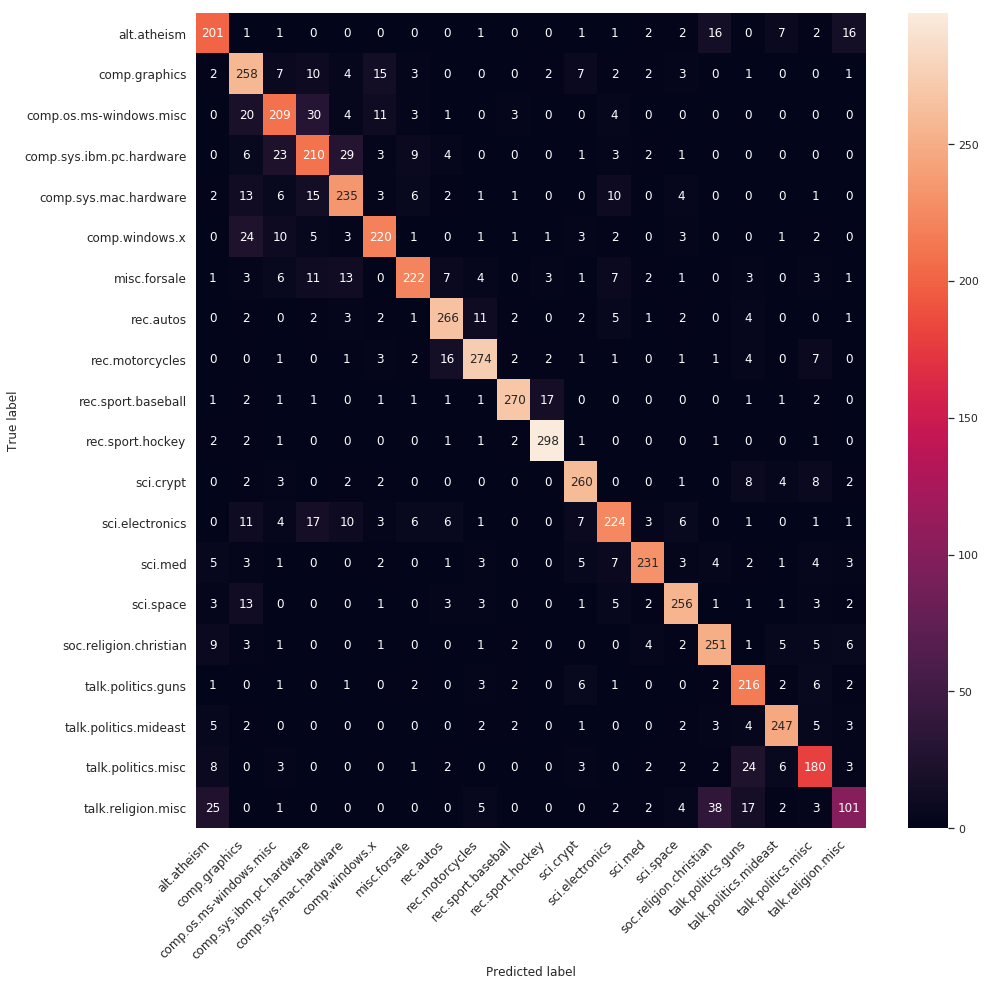

In [25]:
mb = MultinomialNB()
mb.fit(X_selected, y_resampled)
evaluate_model(mb, X_selected, y, X_test_selected, y_test)

### Complement Naive Bayes

For `ComplementNB` we see that the overall accuracy is better than in previous case, but `alt.atheism`, `talk.politics.misc` and `talk.religion.misc` are misclassified even worse.

Accuracy: 0.95 (+/- 0.01)
Accuracy test: 0.81 (+/- 0.00)
Test classification report: 
                          precision    recall  f1-score   support

             alt.atheism       0.79      0.72      0.76       251
           comp.graphics       0.80      0.79      0.79       317
 comp.os.ms-windows.misc       0.75      0.78      0.77       285
comp.sys.ibm.pc.hardware       0.70      0.72      0.71       291
   comp.sys.mac.hardware       0.84      0.79      0.81       299
          comp.windows.x       0.81      0.83      0.82       277
            misc.forsale       0.80      0.73      0.76       288
               rec.autos       0.86      0.88      0.87       304
         rec.motorcycles       0.90      0.91      0.91       316
      rec.sport.baseball       0.90      0.91      0.91       300
        rec.sport.hockey       0.91      0.95      0.93       310
               sci.crypt       0.89      0.93      0.91       292
         sci.electronics       0.85      0.72      0.78

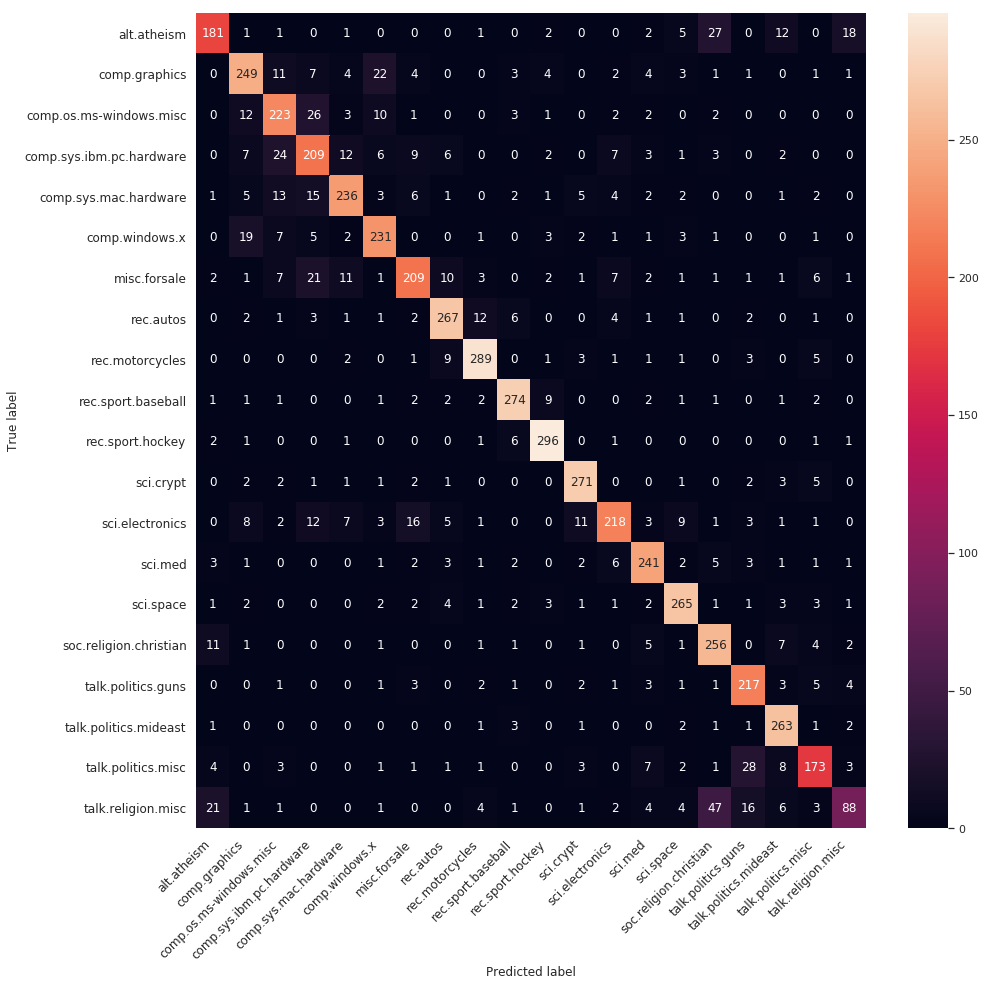

In [26]:
cb = ComplementNB()
cb.fit(X_selected, y_resampled)
evaluate_model(cb, X_selected, y, X_test_selected, y_test)

## Logistic regression
For `LogisticRegression` `alt.atheism` is classified much more better, `talk.politics.misc` and `talk.religion.misc` are still misclassified, but looks better than the previous cases. This classifier but has some problems with hardware of different companies.

Accuracy: 0.98 (+/- 0.00)
Accuracy test: 0.79 (+/- 0.01)
Test classification report: 
                          precision    recall  f1-score   support

             alt.atheism       0.77      0.77      0.77       251
           comp.graphics       0.73      0.77      0.75       317
 comp.os.ms-windows.misc       0.73      0.80      0.77       285
comp.sys.ibm.pc.hardware       0.71      0.73      0.72       291
   comp.sys.mac.hardware       0.83      0.77      0.80       299
          comp.windows.x       0.84      0.79      0.81       277
            misc.forsale       0.75      0.79      0.77       288
               rec.autos       0.84      0.88      0.86       304
         rec.motorcycles       0.94      0.86      0.90       316
      rec.sport.baseball       0.95      0.92      0.93       300
        rec.sport.hockey       0.97      0.94      0.95       310
               sci.crypt       0.94      0.88      0.91       292
         sci.electronics       0.77      0.79      0.78

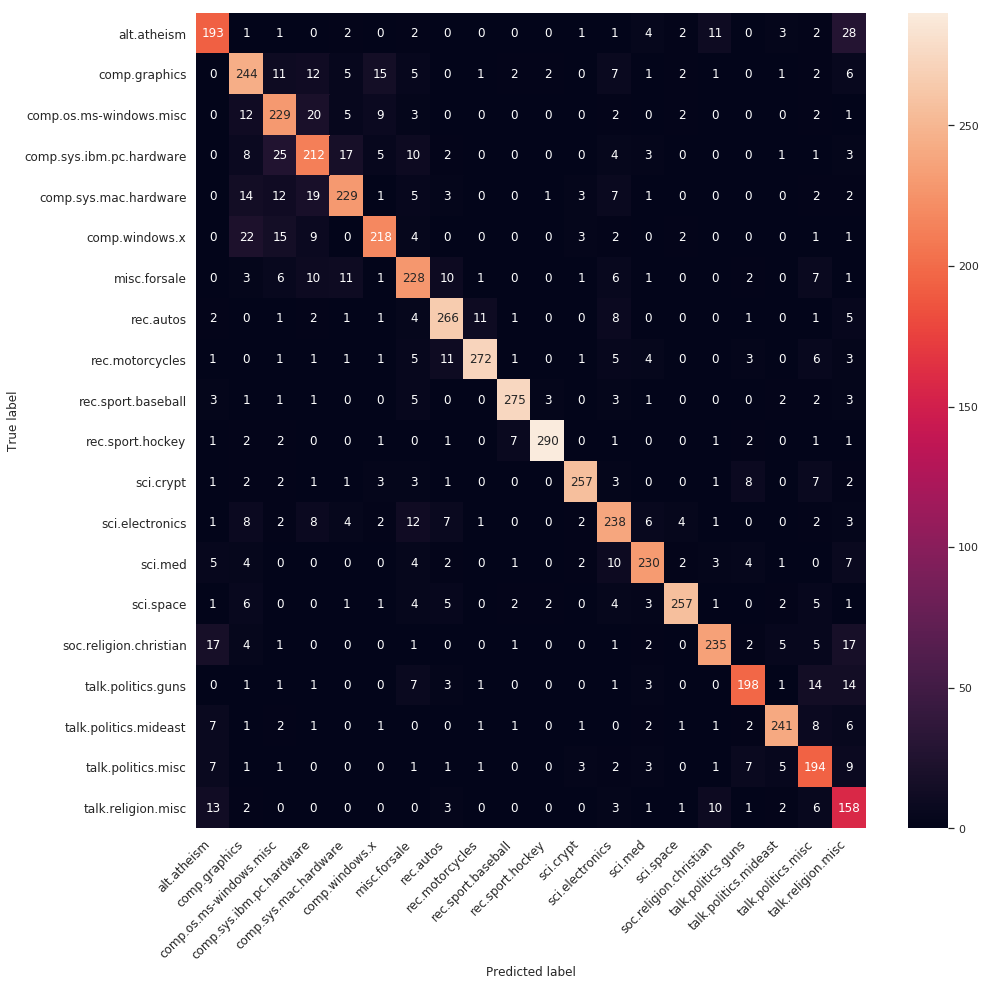

In [27]:
lr = LogisticRegression(C=10000, penalty='l1', multi_class='ovr')
lr.fit(X_selected, y)
evaluate_model(lr, X_selected, y, X_test_selected, y_test)

## Linear SVC
`LinearSVC` looks a lot like `LogisticRegression`, but has more misclassifications in different groups and lover overall test accuracy.

Accuracy: 0.94 (+/- 0.01)
Accuracy test: 0.72 (+/- 0.01)
Test classification report: 
                          precision    recall  f1-score   support

             alt.atheism       0.71      0.73      0.72       251
           comp.graphics       0.68      0.74      0.71       317
 comp.os.ms-windows.misc       0.70      0.72      0.71       285
comp.sys.ibm.pc.hardware       0.68      0.68      0.68       291
   comp.sys.mac.hardware       0.78      0.76      0.77       299
          comp.windows.x       0.76      0.73      0.74       277
            misc.forsale       0.79      0.74      0.76       288
               rec.autos       0.76      0.81      0.78       304
         rec.motorcycles       0.89      0.82      0.85       316
      rec.sport.baseball       0.87      0.85      0.86       300
        rec.sport.hockey       0.91      0.92      0.91       310
               sci.crypt       0.86      0.82      0.84       292
         sci.electronics       0.75      0.73      0.74

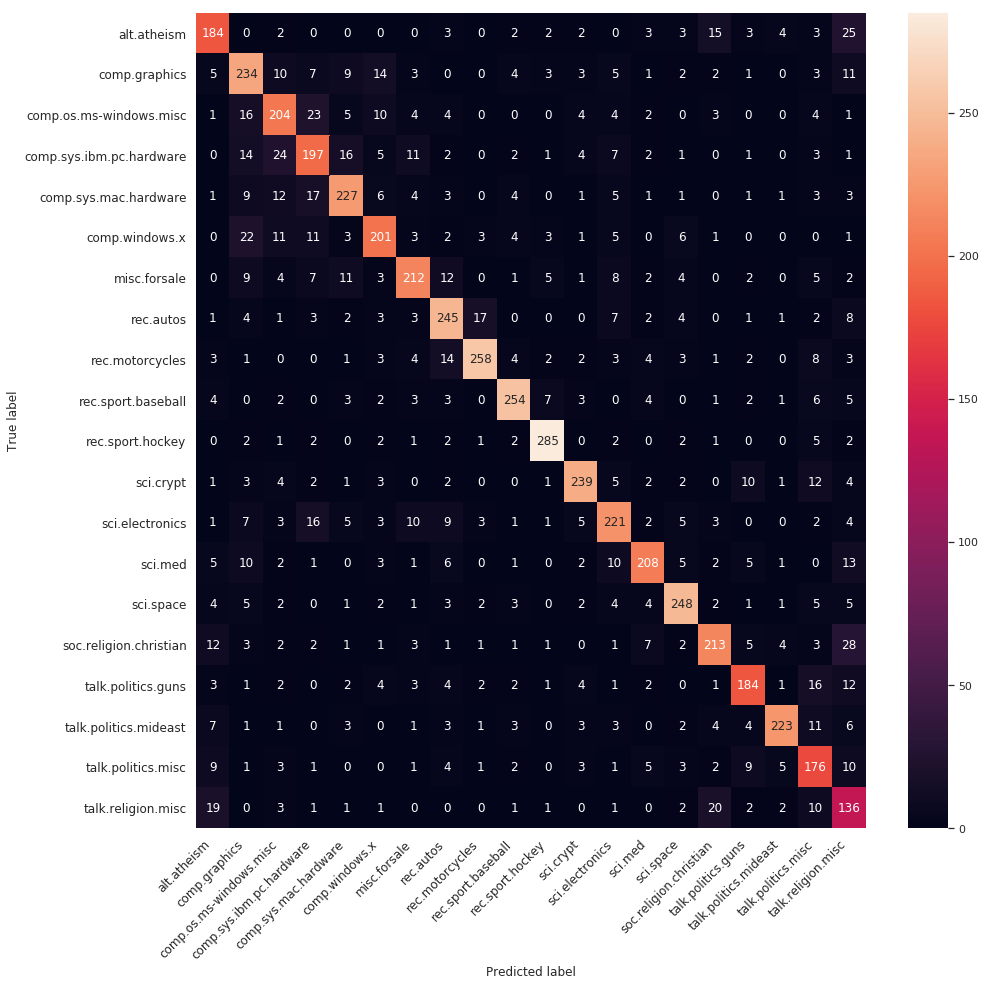

In [28]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(X_selected, y)
evaluate_model(lsvc, X_selected, y, X_test_selected, y_test)

## SGD
`SGDClassifier` one of the most robust concerning `alt.atheism`, `talk.politics.misc` and `talk.religion.misc` groups, with good overall test accuracy and other metrics.

Accuracy: 0.97 (+/- 0.00)
Accuracy test: 0.81 (+/- 0.00)
Test classification report: 
                          precision    recall  f1-score   support

             alt.atheism       0.76      0.76      0.76       251
           comp.graphics       0.69      0.82      0.75       317
 comp.os.ms-windows.misc       0.78      0.80      0.79       285
comp.sys.ibm.pc.hardware       0.74      0.71      0.73       291
   comp.sys.mac.hardware       0.83      0.77      0.80       299
          comp.windows.x       0.80      0.78      0.79       277
            misc.forsale       0.79      0.82      0.80       288
               rec.autos       0.87      0.85      0.86       304
         rec.motorcycles       0.93      0.86      0.89       316
      rec.sport.baseball       0.95      0.90      0.92       300
        rec.sport.hockey       0.98      0.94      0.96       310
               sci.crypt       0.97      0.84      0.90       292
         sci.electronics       0.73      0.82      0.77

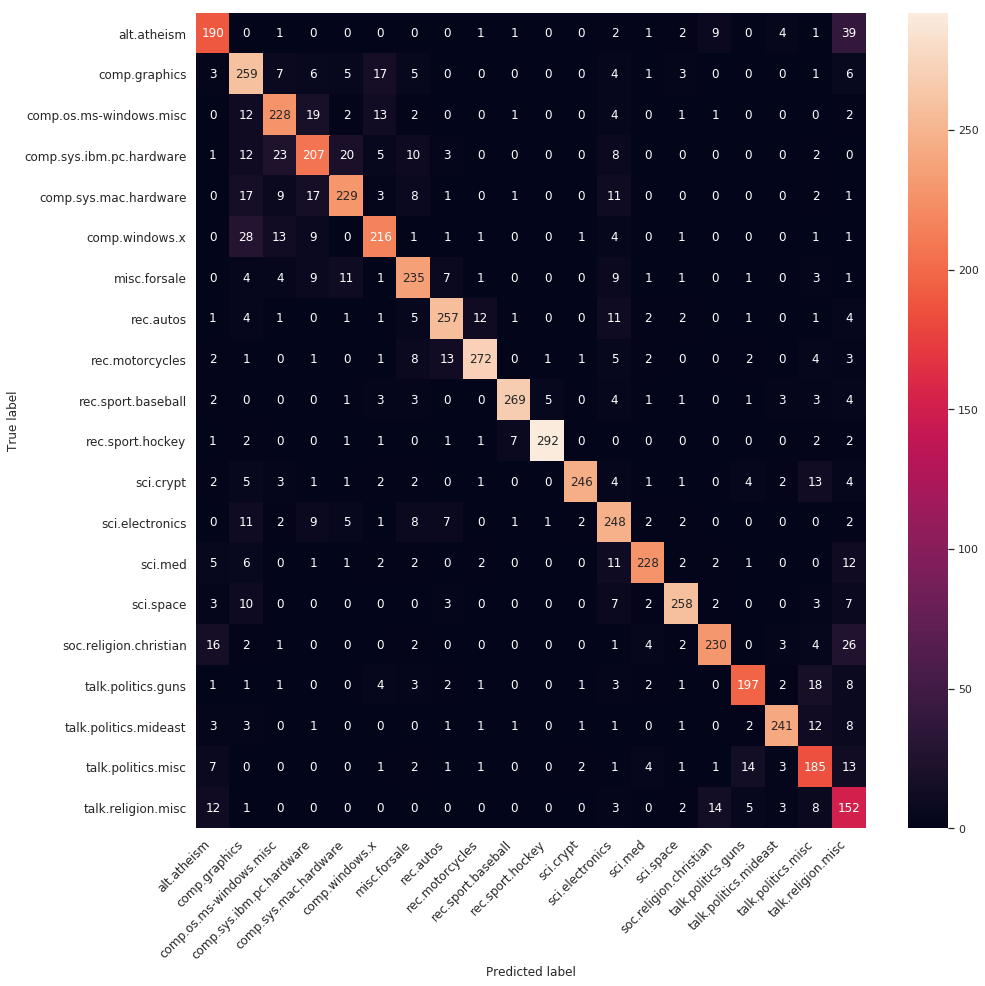

In [29]:
sgd = SGDClassifier(alpha=.0001, max_iter=50, loss='log',
                                       penalty="elasticnet", n_jobs=-1)
sgd.fit(X_selected, y)
evaluate_model(sgd, X_selected, y, X_test_selected, y_test)

If we sum up these results we can see, that `LogisticRegression` and `SGDClassifier` gives us the best results, but sometimes in come cases `MultinominalNB` shows a little bit beter performance. Why not to combine them into soft voting ensemble, that will balance these results. 

In contrast to majority voting (hard voting), soft voting returns the class label as argmax of the sum of predicted probabilities. [Full description of soft voting](https://scikit-learn.org/stable/modules/ensemble.html#weighted-average-probabilities-soft-voting)

Accuracy: 0.98 (+/- 0.00)
Accuracy test: 0.81 (+/- 0.00)
Test classification report: 
                          precision    recall  f1-score   support

             alt.atheism       0.79      0.76      0.78       251
           comp.graphics       0.75      0.82      0.79       317
 comp.os.ms-windows.misc       0.76      0.82      0.79       285
comp.sys.ibm.pc.hardware       0.72      0.74      0.73       291
   comp.sys.mac.hardware       0.87      0.78      0.83       299
          comp.windows.x       0.84      0.82      0.83       277
            misc.forsale       0.81      0.82      0.82       288
               rec.autos       0.89      0.88      0.88       304
         rec.motorcycles       0.93      0.91      0.92       316
      rec.sport.baseball       0.96      0.93      0.94       300
        rec.sport.hockey       0.97      0.95      0.96       310
               sci.crypt       0.95      0.89      0.92       292
         sci.electronics       0.80      0.80      0.80

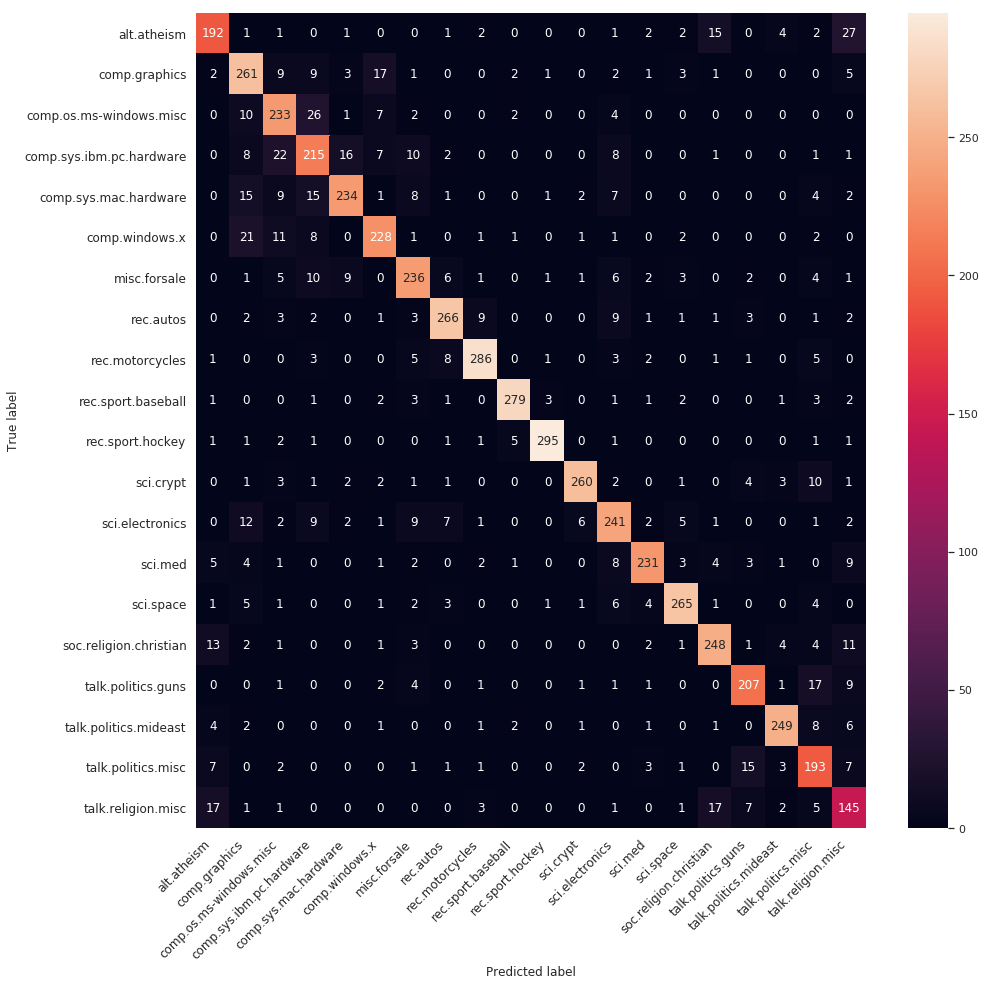

In [30]:
vclf_sgd = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l1', multi_class='ovr')),
        ('mb', MultinomialNB()),
        ('sgd', SGDClassifier(alpha=.0001, max_iter=50, loss='log',
                                       penalty="elasticnet"))
], voting='soft', n_jobs=-1)
vclf_sgd.fit(X_selected, y)
evaluate_model(vclf_sgd, X_selected, y, X_test_selected, y_test)

## Comparison

Now we have to compare all these classifiers and select the best match for this task. I'll do it in a way of difference of the overall accuracy, and accuracy on the problematic groups.

Differect of correctly classified: **alt.atheism**

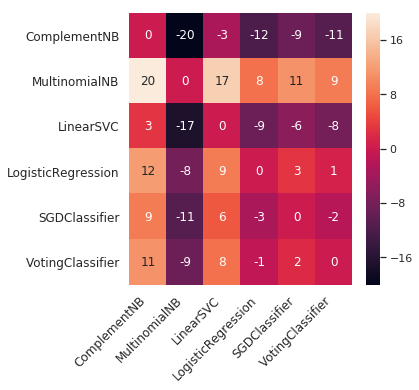

Differect of correctly classified: **comp.sys.mac.hardware**

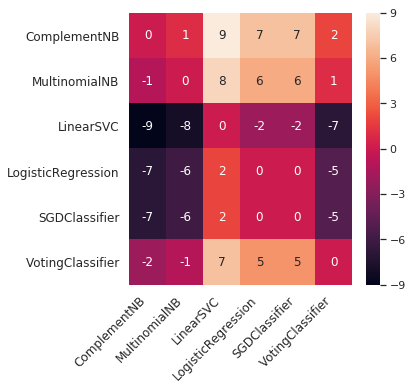

Differect of correctly classified: **talk.politics.misc**

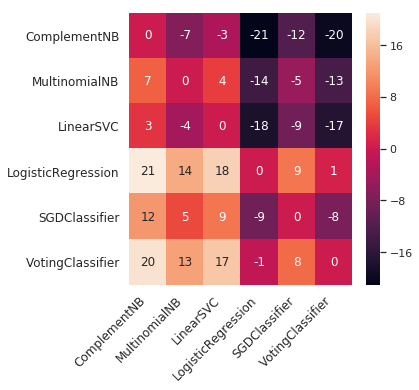

Differect of correctly classified: **talk.religion.misc**

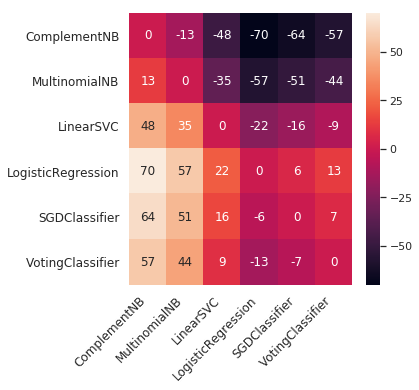

**Overall** correctly classified

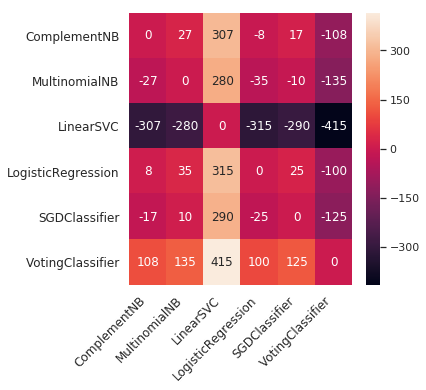

In [31]:
clfs = (('ComplementNB', cb), 
        ('MultinomialNB', mb),
        ('LinearSVC', lsvc),
        ('LogisticRegression', lr),
        ('SGDClassifier', sgd),
        ('VotingClassifier', vclf_sgd))

for _x, _y in ((0,0), (4,4), (18,18), (19,19)):
    mtx = np.zeros((len(clfs), (len(clfs))), dtype=int)

    for i, (label1, clf1) in enumerate(clfs):
        for j, (label2, clf2) in enumerate(clfs):
            mtx[i][j] = (confusion_matrix(y_test, clf1.predict(X_test_selected))
                            -confusion_matrix(y_test, clf2.predict(X_test_selected)))[_x][_y]
    display(Markdown(f"Differect of correctly classified: **{clf2.classes_[_x]}**"))
    print_confusion_matrix(mtx, class_names=[l for l, _ in clfs], xlabel="", ylabel="", figsize=(5,5))
    plt.show()

mtx = np.zeros((len(clfs), (len(clfs))), dtype=int)
for i, (label1, clf1) in enumerate(clfs):
    for j, (label2, clf2) in enumerate(clfs):
        mtx[i][j] = (confusion_matrix(y_test, clf1.predict(X_test_selected))
                        -confusion_matrix(y_test, clf2.predict(X_test_selected))).diagonal().sum()
display(Markdown(f"**Overall** correctly classified"))
print_confusion_matrix(mtx, class_names=[l for l, _ in clfs], xlabel="", ylabel="", figsize=(5,5))

Now we can create a reusable pipline, which we can use in production or even on other datset

In [32]:
import re
import string

from sklearn.base import TransformerMixin, BaseEstimator

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, text_attribute):
        self.text_attribute = text_attribute
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, *_):
        X_copy = X.copy()
        return X_copy[self.text_attribute].apply(self._preprocess_text)
    
    def _preprocess_text(self, text):
        return self._lemmatize(self._leave_letters_only(self._clean(text)))
    
    def _clean(self, text):
        bad_symbols = '!"#%&\'*+,-<=>?[\\]^_`{|}~'
        text_without_symbols = text.translate(str.maketrans('', '', bad_symbols))

        text_without_bad_words = ''
        for line in text_without_symbols.split('\n'):
            if not line.lower().startswith('from:') and not line.lower().endswith('writes:'):
                text_without_bad_words += line + '\n'

        clean_text = text_without_bad_words
        email_regex = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
        regexes_to_remove = [email_regex, r'Subject:', r'Re:']
        for r in regexes_to_remove:
            clean_text = re.sub(r, '', clean_text)

        return clean_text
    
    def _leave_letters_only(self, text):
        text_without_punctuation = text.translate(str.maketrans('', '', string.punctuation))
        return ' '.join(re.findall("[a-zA-Z]+", text_without_punctuation))
    
    def _lemmatize(self, text):
        doc = nlp(text)
        words = [x.lemma_ for x in [y for y in doc if not y.is_stop and y.pos_ != 'PUNCT' 
                                    and y.pos_ != 'PART' and y.pos_ != 'X']]
        return ' '.join(words)

In [33]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [34]:
from imblearn.pipeline import Pipeline

text_classification_pipeline = Pipeline([
    ('text_preprocessor', TextPreprocessor(text_attribute='text')),
    ('vectorizer', TfidfVectorizer(analyzer = "word", max_features=10000)),
    ('balancer', InstanceHardnessThreshold(n_jobs=-1,
                                 estimator=CalibratedClassifierCV(
                                     LinearSVC(C=100, penalty='l1', max_iter=500, dual=False)
                                 ))),
    ('todense_converter', DenseTransformer()),
    ('scaler', MinMaxScaler()),
    ('feature_selector', SelectFromModel(LinearSVC(C=100, penalty='l1', max_iter=500, dual=False), prefit=False)),
    ('classifier', VotingClassifier(estimators=[
                         ('lr', LogisticRegression(C=10000, penalty='l1', multi_class='ovr')),
                         ('mb', MultinomialNB()),
                         ('sgd', SGDClassifier(alpha=.0001, max_iter=50, loss='log', penalty="elasticnet"))
                    ], voting='soft', n_jobs=-1))
])

Let's test our pipeline only over parent categories.

In [35]:
parent_cats = (
    ('comp', ('comp.graphics',
            'comp.os.ms-windows.misc',
            'comp.sys.ibm.pc.hardware',
            'comp.sys.mac.hardware',
            'comp.windows.x')),
    ('foresale', ('misc.forsale',)),
    ('rec', ('rec.autos',
            'rec.motorcycles',
            'rec.sport.baseball',
            'rec.sport.hockey')),
    ('talk', ('talk.politics.misc',
            'talk.politics.guns',
            'talk.politics.mideast')),
    ('sci', ('sci.crypt',
            'sci.electronics',
            'sci.med',
            'sci.space')),
    ('religion', ('talk.religion.misc',
                'alt.atheism',
                'soc.religion.christian'))
)

In [36]:
df_parent = df

for new_name, lst in parent_cats:
    df_parent.loc[df_parent['category'].isin(lst), 'category'] = new_name

In [37]:
train, test = train_test_split(df_parent, test_size=0.3)

X_p = train.drop(columns=['category'])
y_p = train['category']

X_p_test = test.drop(columns=['category'])
y_p_test = test['category']

In [38]:
%%time
pipeline = text_classification_pipeline
pipeline.fit(X_p, y_p)

CPU times: user 11min 50s, sys: 2.19 s, total: 11min 52s
Wall time: 12min 18s


In [39]:
%%time
y_pred = pipeline.predict(X_p)

CPU times: user 10min 14s, sys: 5.21 s, total: 10min 19s
Wall time: 10min 18s


In [40]:
%%time
y_test_pred = pipeline.predict(X_p_test)

CPU times: user 4min 21s, sys: 3.72 s, total: 4min 25s
Wall time: 4min 25s


              precision    recall  f1-score   support

        comp       0.91      0.83      0.87      3425
    foresale       0.42      1.00      0.60       688
         rec       0.95      0.87      0.90      2774
    religion       0.92      0.87      0.89      1695
         sci       0.90      0.76      0.83      2744
        talk       0.86      0.90      0.88      1853

   micro avg       0.85      0.85      0.85     13179
   macro avg       0.83      0.87      0.83     13179
weighted avg       0.88      0.85      0.86     13179



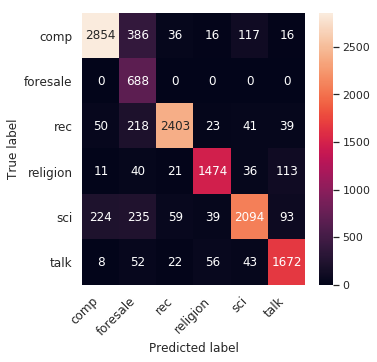

In [41]:
print(classification_report(y_p, y_pred, target_names=pipeline.classes_))
print_confusion_matrix(confusion_matrix(y_p, y_pred), class_names=pipeline.classes_, figsize=(5,5), fontsize=12)

              precision    recall  f1-score   support

        comp       0.89      0.83      0.86      1456
    foresale       0.40      0.94      0.56       284
         rec       0.94      0.85      0.89      1203
    religion       0.91      0.87      0.89       729
         sci       0.89      0.76      0.82      1205
        talk       0.86      0.91      0.88       772

   micro avg       0.84      0.84      0.84      5649
   macro avg       0.81      0.86      0.82      5649
weighted avg       0.87      0.84      0.85      5649



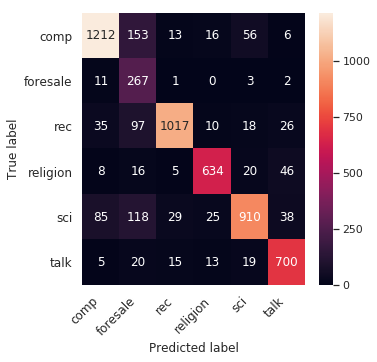

In [42]:
print(classification_report(y_p_test, y_test_pred, target_names=pipeline.classes_))
print_confusion_matrix(confusion_matrix(y_p_test, y_test_pred), class_names=pipeline.classes_, figsize=(5,5), fontsize=12)

Here we can see that foresale is terribly misclassified, even though in our pipline we made class balancing. Of course every specific task, requires paramters tuning. I could be continuation of this project.

Let's try our pipeline on a completely different dataset I have found on web [link](https://www.kaggle.com/yufengdev/bbc-fulltext-and-category/downloads/bbc-text.csv/2)

In [43]:
df_bbc = pd.read_csv('../input/newsgroup20bbcnews/bbc-text.csv')

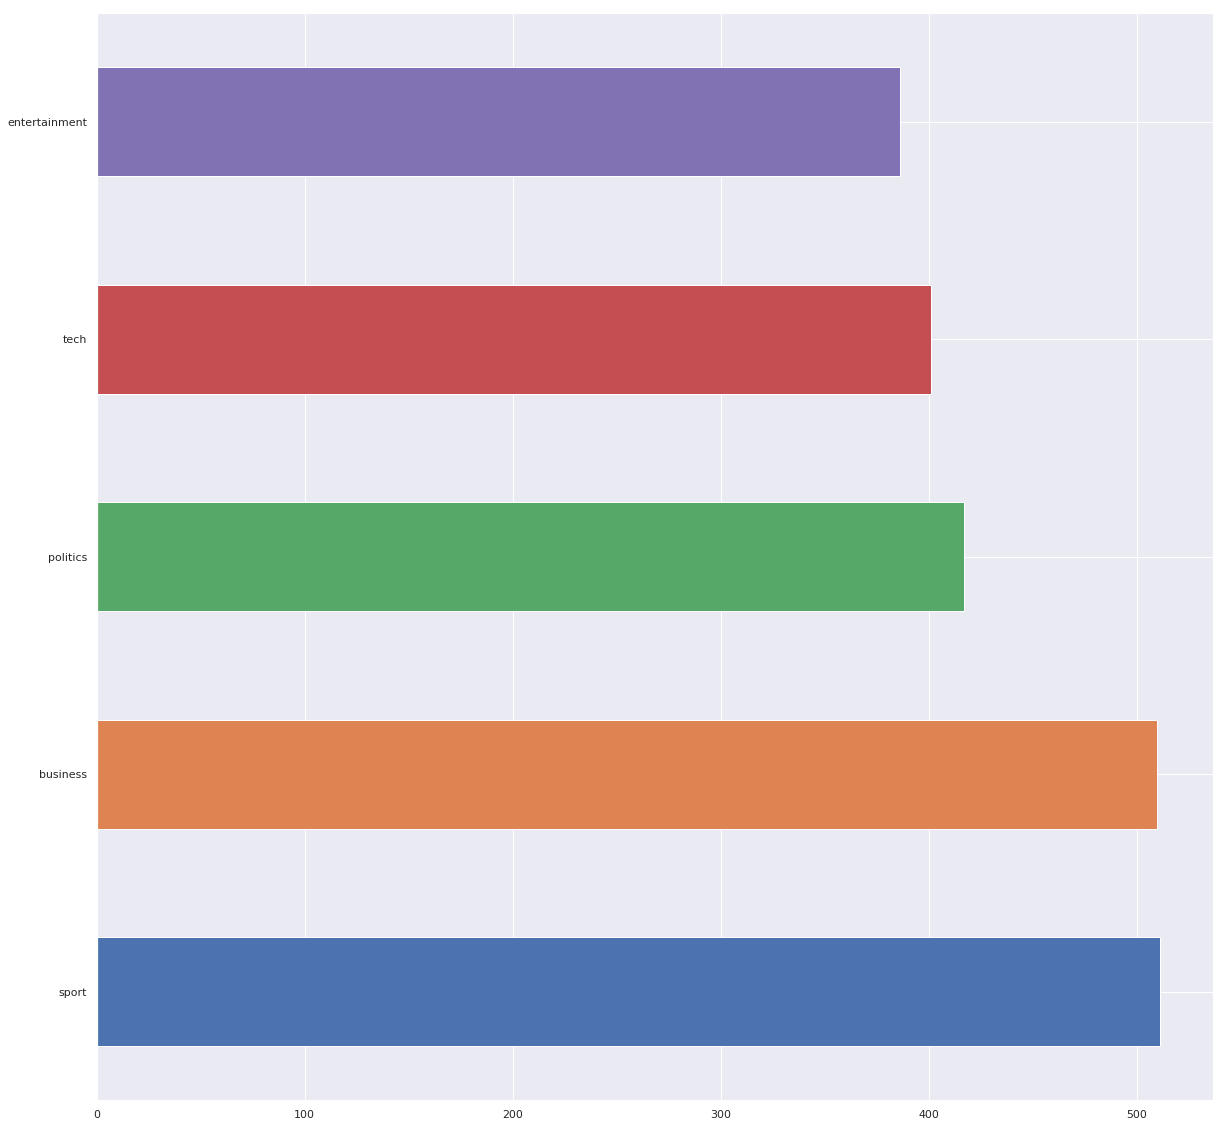

In [44]:
df_bbc.category.value_counts().plot.barh()

In [45]:
train, test = train_test_split(df_bbc, test_size=0.3)

X_bbc = train.drop(columns=['category'])
y_bbc = train['category']

X_bbc_test = test.drop(columns=['category'])
y_bbc_test = test['category']

In [46]:
%%time
pipeline = text_classification_pipeline
pipeline.fit(X_bbc, y_bbc)

CPU times: user 1min 47s, sys: 572 ms, total: 1min 48s
Wall time: 1min 53s


In [47]:
%%time
y_pred = pipeline.predict(X_bbc)

CPU times: user 1min 40s, sys: 384 ms, total: 1min 40s
Wall time: 1min 40s


In [48]:
%%time
y_test_pred = pipeline.predict(X_bbc_test)

CPU times: user 43.6 s, sys: 380 ms, total: 43.9 s
Wall time: 43.7 s


               precision    recall  f1-score   support

     business       1.00      0.93      0.96       363
entertainment       0.98      1.00      0.99       273
     politics       0.95      0.99      0.97       281
        sport       0.99      0.99      0.99       357
         tech       0.97      0.99      0.98       283

    micro avg       0.98      0.98      0.98      1557
    macro avg       0.98      0.98      0.98      1557
 weighted avg       0.98      0.98      0.98      1557



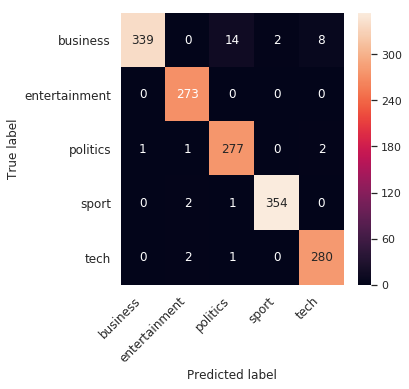

In [49]:
print(classification_report(y_bbc, y_pred, target_names=pipeline.classes_))
print_confusion_matrix(confusion_matrix(y_bbc, y_pred), class_names=pipeline.classes_, figsize=(5,5), fontsize=12)

               precision    recall  f1-score   support

     business       0.98      0.94      0.96       147
entertainment       0.98      0.98      0.98       113
     politics       0.99      0.98      0.98       136
        sport       0.99      0.99      0.99       154
         tech       0.93      0.97      0.95       118

    micro avg       0.97      0.97      0.97       668
    macro avg       0.97      0.97      0.97       668
 weighted avg       0.97      0.97      0.97       668



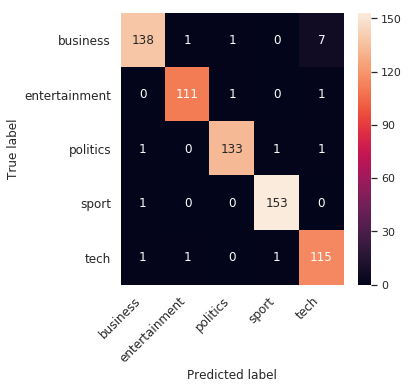

In [50]:
print(classification_report(y_bbc_test, y_test_pred, target_names=pipeline.classes_))
print_confusion_matrix(confusion_matrix(y_bbc_test, y_test_pred), class_names=pipeline.classes_, figsize=(5,5), fontsize=12)

We beat the authors solution! So this pipeline is reusable, but of course every concrete task needs tuning.

# Hardware benchmark
My hardware:

Processor: Intel® Core™ i7-8750H CPU @ 2.20GHz × 12

RAM: 16 GB

### News Group dataset:

RAM consuming(max): 10 GB

Fit time: 12m 30s (17.572 samples/s)

Predict time: 4m 30s (20.9 samples/s)

The most time consuming part is text processing, which can be somehow parallelized and optimized, but I'll leave for the future work. For now the model is production ready, but the speed is not, the algorithm needs to be optimized.
